In [ ]:
import tensorflow as tf
print(tf.__version__)

2.6.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
base_dir = '/content/drive/MyDrive/datasets/lung_image_sets'

In [ ]:
os.listdir(base_dir)

['lung_scc', 'lung_n', 'lung_aca']

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
 
train_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=20,
                    horizontal_flip=True,
                    shear_range = 0.2,
                    fill_mode = 'nearest',
                    validation_split=0.2)
test_datagen = ImageDataGenerator(
                    rescale=1./255,
                    validation_split=0.2)
train_generator = train_datagen.flow_from_directory(base_dir,
                                                    target_size=(150,150),
                                                    seed=42,
                                                    subset='training')
validation_generator = test_datagen.flow_from_directory(base_dir,
                                                        target_size=(150,150),
                                                        seed=42,
                                                        subset='validation')

Found 12000 images belonging to 3 classes.
Found 3000 images belonging to 3 classes.


In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(512, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

In [ ]:
model.compile(loss = 'categorical_crossentropy',
              optimizer = 'adam',
              metrics=['accuracy'])

In [ ]:
desired_acc = 0.92
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epochs, logs={}):
    if(logs.get('accuracy')>desired_acc and logs.get('val_accuracy')>desired_acc):
      print('Reached 92% accuracy, training stop!')
      self.model.stop_training = True

callbacks = myCallback()

In [ ]:
history = model.fit(
      train_generator,
      steps_per_epoch=35,  # berapa batch yang akan dieksekusi pada setiap epoch
      epochs=50, # tambahkan eposchs jika akurasi model belum optimal
      validation_data=validation_generator, # menampilkan akurasi pengujian data validasi
      validation_steps=25,  # berapa batch yang akan dieksekusi pada setiap epoch
      verbose=2,
      callbacks=[callbacks])

Epoch 1/50
35/35 - 497s - loss: 0.8341 - accuracy: 0.5830 - val_loss: 0.5198 - val_accuracy: 0.7950
Epoch 2/50
35/35 - 417s - loss: 0.5098 - accuracy: 0.7750 - val_loss: 0.6820 - val_accuracy: 0.6725
Epoch 3/50
35/35 - 347s - loss: 0.4480 - accuracy: 0.8080 - val_loss: 0.5334 - val_accuracy: 0.7425
Epoch 4/50
35/35 - 307s - loss: 0.3868 - accuracy: 0.8375 - val_loss: 0.3594 - val_accuracy: 0.8625
Epoch 5/50
35/35 - 264s - loss: 0.3608 - accuracy: 0.8679 - val_loss: 0.3491 - val_accuracy: 0.8650
Epoch 6/50
35/35 - 245s - loss: 0.3329 - accuracy: 0.8732 - val_loss: 0.3603 - val_accuracy: 0.8375
Epoch 7/50
35/35 - 221s - loss: 0.3121 - accuracy: 0.8804 - val_loss: 0.2624 - val_accuracy: 0.8938
Epoch 8/50
35/35 - 211s - loss: 0.2875 - accuracy: 0.8929 - val_loss: 0.2553 - val_accuracy: 0.9000
Epoch 9/50
35/35 - 178s - loss: 0.2952 - accuracy: 0.8750 - val_loss: 0.2550 - val_accuracy: 0.9050
Epoch 10/50
35/35 - 173s - loss: 0.3226 - accuracy: 0.8670 - val_loss: 0.3057 - val_accuracy: 0.8925

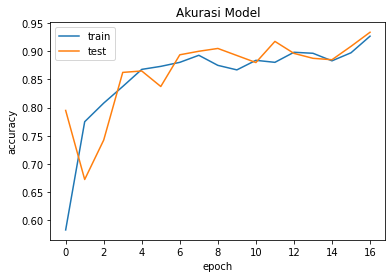

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Akurasi Model')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

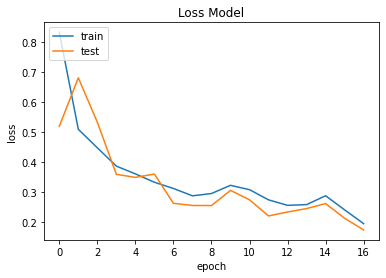

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# Konversi model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmpb6doov01/assets


In [ ]:
with tf.io.gfile.GFile('model.tflite', 'wb') as f:
  f.write(tflite_model)